# Google Collab

Colaboratory, or “Colab” for short, is a product from Google Research. Colab allows anybody to write and execute arbitrary python code through the browser. 

1.   Write & Execute Python code
2.   Use Linux Commands (with '!')
3.   Comment on your work with 'Text' function



[More Info About Google Collab](https://research.google.com/colaboratory/faq.html)

In [ ]:
print('Hello World')

Hello World


# Reference
Notebook from: https://www.kaggle.com/code/mohamedchahed/brain-tumor-mri-classification-with-vgg19

Modified for Datascience practical Presentation

Original Author: MOHAMED CHAHED

Installing package:

In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing packages

In [ ]:
# Import necessary libraries 
import os
import numpy as np
import cv2 
import imutils
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Dataset Download

**Download** the dataset:
https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [ ]:
!git clone https://github.com/nkampel/data_science_tutorial.git;
!unzip -o data_science_tutorial/archive.zip;

Cloning into 'data_science_tutorial'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), 15.36 MiB | 9.09 MiB/s, done.
Archive:  data_science_tutorial/archive.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/

# Cleaning Data

We found that there where mislabled images in the dataset. So we  manualy, deleted them from the directory!

In [ ]:
!rm no/N1.JPG no/N15.jpg no/N16.jpg no/N17.jpg

# Sorting the Data

Images are labelet according to expected outputs 'yes' is labeled as 1, 'no' is labeled as 0.

Afterwards Data should be split as **test** and **training** data.

In [ ]:
# Define the path to the dataset
IMG_PATH = 'brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        
         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 183
Validation set size: 62
Test set size: 8


# Preparation For Ploting
Dataset path is created.

Just for visualisation it is important to look at the data and see that we are reading it correctly.

For the plotting purposes labels and colors are defined as a dictionary.

Now we like to plot a random batch of images, corresponding to both classes!



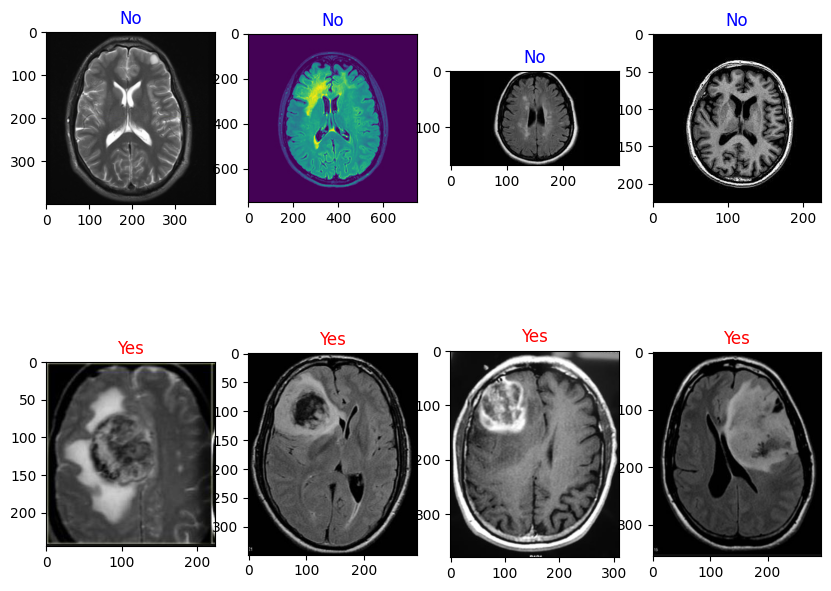

In [ ]:
%matplotlib inline

# Define the path to the dataset
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'

# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

show_number = 4
# Plot some images from the train set for each label
fig, axs = plt.subplots(2, show_number, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label]
    images = np.random.choice(images, size=show_number)
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

# Function for image preprocessing

Images dataset is argument for this funtion.

For every image it resizes the image with [openCV](https://docs.opencv.org) and removes noise.

[Read more about 'erode' & 'dilate' ](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html)

Finds contours and then gets the biggest contour in the image. Next step is to find extreme points (lowest bottom, highest top, right and left coordinates of contour). 

Final step is to cut the image with those extreme points so unnecessary area will be removed and the area of the interest is left, afterwards **returns** numpy array of images.

In [ ]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

# Apply the funtion

Preprocessing function is applyed to **training**, **validation** and **test** datasets


In [ ]:
# Apply the preprocessing to all the data subsets 
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

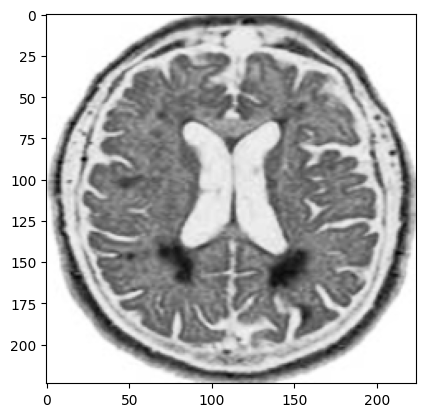

In [ ]:
#Show cropped image
plt.imshow(X_train_pre[12][:,:,2],cmap='Greys')

In [ ]:
# Transform the subsets to numpy arrays 
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

# Plot images
After using **pre_process()** function with **X_train_pre** images ploting them for representation.

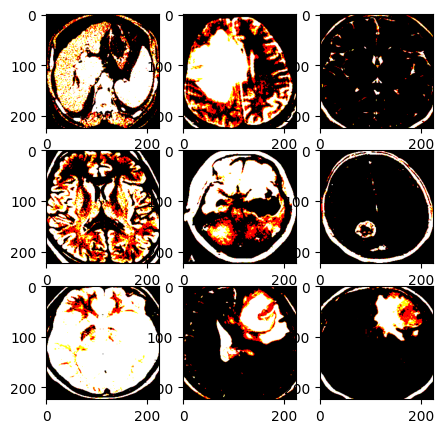

In [ ]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap='Greys')
plt.show()

# Training of the Network

**VGG-19** is a convolutional neural network that is 19 layers deep. It is **pre-trained** model for image processing that is used in this project for improving results.

After using pre-trained model to make it work for the specific project it is best to use additional model on top with a few layers.

To avoid retraining already pre-trained model we **freeze** it's weights.

Model should be compiled to start training.


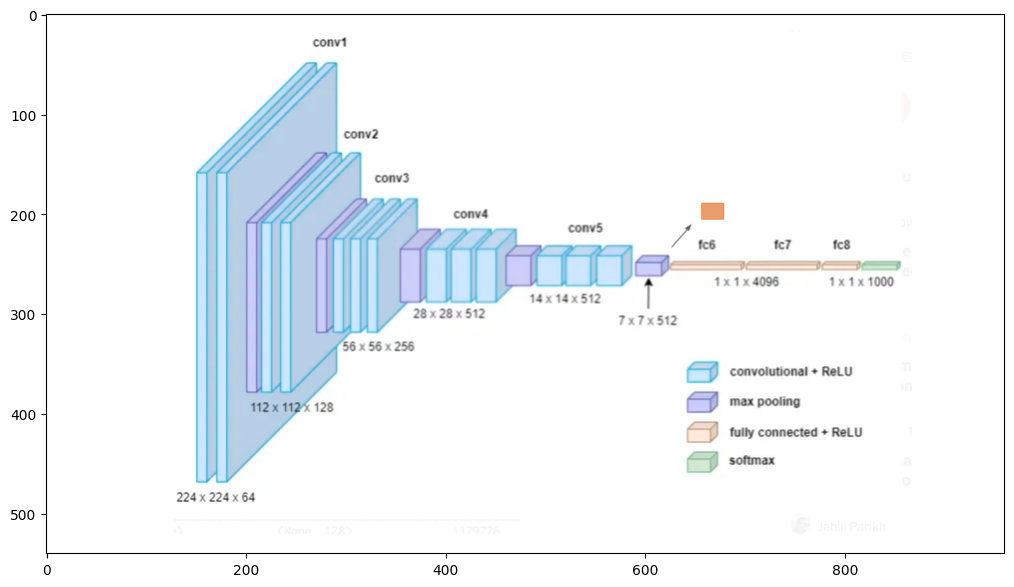

In [ ]:
# Model architecture
img_color = cv2.imread('/content/data_science_tutorial/vgg19.png',-1)
fig, ax = plt.subplots(figsize=(18, 7))
ax.imshow(img_color)

In [ ]:
# Load the pre-trained VGG19 model
base_model = VGG19(
weights='imagenet',
include_top=False,
input_shape=(224,224) + (3,)
)

# Create a new model by adding a few layers on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile(
loss='binary_crossentropy',
optimizer=Adam(),
metrics=['accuracy']
)

# Print the summary of the model
model.summary()

# Define the training data generator with necessary data augmentation techniques
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Create the training data generator using the training dataset and the data generator
train_generator = train_datagen.flow(
X_train_pre_vgg,
y_train,
batch_size=32
)

# Define a callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5)

# Define a callback to stop the training when validation accuracy reaches 90%
class StopOnAccuracy(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9:
            print("\nReached 90% accuracy, stopping training...")
            self.model.stop_training = True

# Define the validation data generator with appropriate data preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the validation data generator using the validation dataset and the data generator
val_generator = val_datagen.flow(X_val_pre_vgg, y_val, batch_size=18)

# Train the model using the training data generator, validation data generator and the defined callbacks
history = model.fit(
train_generator,
epochs=3,
validation_data=val_generator,
callbacks=[reduce_lr,StopOnAccuracy()]
)

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/3
6/6 [==============================] - 24s 2s/step - loss: 0.9542 - accuracy: 0.5410 - val_loss:

In [ ]:
    results = model.evaluate(X_val_pre_vgg, np.array(y_val), batch_size=64)
    final_val_loss, final_val_accuracy = results[0]
    print('results:')
    print(results)

1/1 [==============================] - 7s 7s/step - loss: 2.9114 - accuracy: 0.8065
results:
[2.911356210708618, 0.8064516186714172]


2.911356210708618

# Performance

Model should be afterwards inspected with validation accuracy curves. How was epoch to accuracy distributed on a plot.

Also it is important to inspect Loss VS epoch. This plots and differance between training and validation curves actually shows what was the **performance** of the training model throught training process.

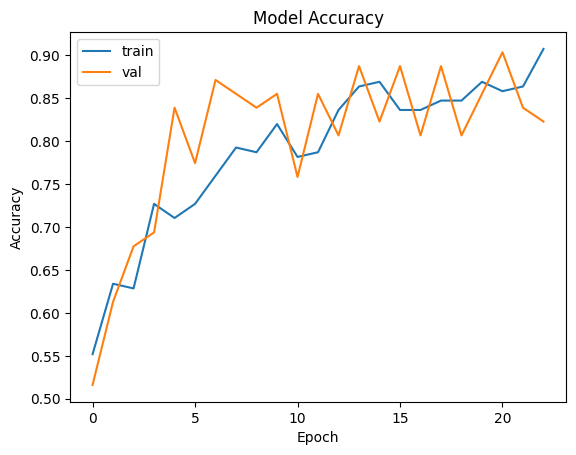

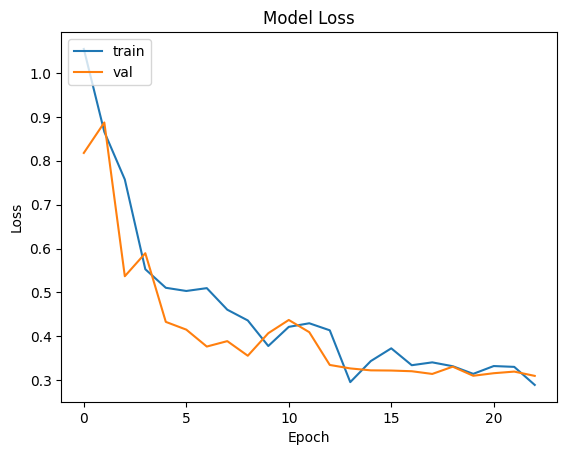

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediction 

**Prediction** refers to the output of an algorithm after it has been trained on a historical dataset and applied to new data when forecasting the likelihood of a particular outcome

A **confusion matrix** is a predictive analytics tool. Specifically, it is a table that displays and compares actual values with the model's predicted values. Within the context of machine learning, a confusion matrix is utilized as a metric to analyze how a machine learning classifier performed on a dataset.



1/1 [==============================] - 0s 200ms/step


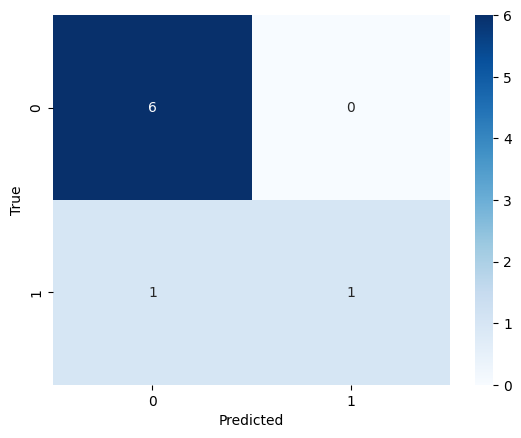

Test accuracy: 0.875


In [ ]:
# Make predictions on X_test_pre
y_pred = model.predict(X_test_pre)
y_pred = np.round(y_pred).astype(int)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', test_accuracy)